##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Automatic differentiation and gradient tape

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/notebooks/automatic_differentiation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/notebooks/automatic_differentiation.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In the previous tutorial we introduced `Tensor`s and operations on them. In this tutorial we will cover [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), a key technique for optimizing machine learning models.

## Setup


In [2]:
import tensorflow as tf
tf.enable_eager_execution()

print('Using CUDA: %s' % tf.test.is_built_with_cuda())

# check jupyter notebook console output to ensure that we are using GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

tfe = tf.contrib.eager # Shorthand for some symbols

Using CUDA: True


## Derivatives of a function

TensorFlow provides APIs for *automatic differentiation* - computing the derivative of a function. The way that more closely mimics the math is to encapsulate the computation in a Python function, say `f`, and use `tfe.gradients_function` to create a function that computes the derivatives of `f` *with respect to its arguments*. If you're familiar with [autograd](https://github.com/HIPS/autograd) for differentiating numpy functions, this will be familiar. For example: 

In [3]:
from math import pi

BASICALLY_ZERO = 1e-7

def f(x):
    return tf.square(tf.sin(x))

def f_actual_derivative(x):
    return 2*tf.sin(x)*tf.cos(x)

assert f(pi/2).numpy() == 1.0


# grad_f will return a list of derivatives of f
# with respect to its arguments. Since f() has a single argument,
# grad_f will return a list with a single element.
grad_f = tfe.gradients_function(f)

assert tf.abs(grad_f(pi/2)[0]).numpy() < BASICALLY_ZERO


def tensor2boolean(tensor):
    # see https://stackoverflow.com/a/34961322/8236733
    return tf.reshape(tensor, [])

zero22pi_test_range = tf.range(0, 2*pi, delta=0.3) 
for x in zero22pi_test_range:
    assert tensor2boolean(tf.abs(grad_f(x) - f_actual_derivative(x))) < BASICALLY_ZERO

### Higher-order gradients

The same API can be used to differentiate as many times as you like:


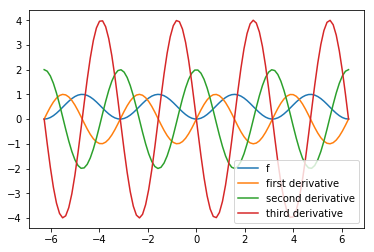

In [5]:
def f(x):
    return tf.square(tf.sin(x))

def grad(f):
    return lambda x: tfe.gradients_function(f)(x)[0]

x = tf.lin_space(-2*pi, 2*pi, 100)  # 100 points between -2π and +2π

import matplotlib.pyplot as plt

plt.plot(x, f(x), label="f")
plt.plot(x, grad(f)(x), label="first derivative")
plt.plot(x, grad(grad(f))(x), label="second derivative")
plt.plot(x, grad(grad(grad(f)))(x), label="third derivative")
plt.legend()
plt.show()

## Gradient tapes

**Every differentiable TensorFlow operation has an associated gradient function**. For example, the gradient function of `tf.square(x)` would be a function that returns `2.0 * x`.  To compute the gradient of a *user-defined function* (like `f(x)` in the example above), TensorFlow first **"records" all the operations applied** to compute the output of the function. We call this record a *"tape"*. It then **uses that tape and the gradients functions associated with each primitive operation** to compute the gradients of the user-defined function using [reverse mode differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

Since operations are recorded **as they are executed**, Python control flow (using `if`s and `while`s for example) is naturally handled:



In [6]:
def x_to_the_y_power(x, y):
    output = 1
    # Must use range(int(y)) instead of range(y) in Python 3 when
    # using TensorFlow 1.10 and earlier. Can use range(y) in 1.11+
    for i in range(int(y)):
        output = tf.multiply(output, x)
    return output

def grad_x_to_the_y_power(x, y):
    # Return the gradient of `f` with respect to it's first parameter
    return tfe.gradients_function(x_to_the_y_power)(x, y)[0]

assert x_to_the_y_power(3.0, 2).numpy() == 9.0   # f(x, 2) is essentially x * x
assert grad_x_to_the_y_power(3.0, 2).numpy() == 6.0   # And its gradient will be 2 * x

assert x_to_the_y_power(4.0, 3).numpy() == 64.0  # f(x, 3) is essentially x * x * x
assert grad_x_to_the_y_power(4.0, 3).numpy() == 48.0  # And its gradient will be 3 * x * x

At times it may be inconvenient to encapsulate computation of interest into a function. For example, if you want the gradient of the output *with respect to intermediate values computed in the function*. In such cases, the slightly more verbose but explicit [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) context is useful. All computation inside the context of a `tf.GradientTape` is "recorded".

For example:

In [10]:
fixed_input_x = tf.ones((2, 2))
  
# TODO(b/78880779): Remove the 'persistent=True' argument and use
# a single t.gradient() call when the bug is resolved.
with tf.GradientTape(persistent=True) as tape:
    # TODO(ashankar): Explain with "watch" argument better?
    tape.watch(fixed_input_x)
    y = tf.reduce_sum(fixed_input_x)
    z = tf.multiply(y, y)
    # z = y^2
    # => dz/dy = 2y = 2*sum([[1,1],[1,1]]) = 2*4 = 8

# Use the same tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = tape.gradient(z, y)
print(dz_dy)
assert dz_dy.numpy() == 8.0

# Derivative of z with respect to the original input tensor x
dz_dx = tape.gradient(z, fixed_input_x)
print(dz_dx)
for i in [0, 1]:
    for j in [0, 1]:
        assert dz_dx[i][j].numpy() == 8.0

tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


### Higher-order gradients

Operations inside of the `GradientTape` context manager are recorded for automatic differentiation. **If gradients are computed in that context, then the gradient computation is recorded as well**. As a result, the exact same API works for higher-order gradients as well. For example:

In [13]:
# TODO(ashankar): Should we use the persistent tape here instead? Follow up on Tom and Alex's discussion

x = tf.constant(1.0)  # Convert the Python 1.0 to a Tensor object

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        t2.watch(x)
        y = x * x * x
        # => dy/dx = 3x^2 = 3(1) = 3
        #d2y/dx2 = 6x = 6
        
    # Compute the gradient inside the 't' context manager
    # which means the gradient computation is differentiable as well.
    dy_dx = t2.gradient(y, x)
    print(dy_dx)
    
d2y_dx2 = t.gradient(dy_dx, x)
print(d2y_dx2)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


## Next Steps

In this tutorial we covered gradient computation in TensorFlow. With that we have enough of the primitives required to build an train neural networks, which we will cover in the [next tutorial](https://github.com/tensorflow/models/tree/master/official/contrib/eager/python/examples/notebooks/3_neural_networks.ipynb).